In [1]:
"""
Graph Construction for GCN Layer

Architecture uses Graph Convolutional Networks (GCN) to propagate information 
between biologically related genes. This notebook builds a gene-gene similarity 
graph based on expression correlation patterns.

Goal: Create edge_index for torch_geometric GCNConv layer
"""

import numpy as np
import torch, gc
import matplotlib.pyplot as plt
import time

# Load standardized expression matrix: [samples, genes]
X_std = np.load("./data/archs4/processed_short_proteins/train_X_std_short.npy")
print("Loaded expression:", X_std.shape)

# Transpose to [genes, samples] for gene-gene correlation
Xg = X_std.T.astype(np.float32)
num_genes = Xg.shape[0]
print(f"Genes: {num_genes:,}, Samples: {Xg.shape[1]:,}")

Loaded expression: (76286, 19357)
Genes: 19,357, Samples: 76,286
Genes: 19,357, Samples: 76,286


In [2]:
# Compute gene-gene correlation matrix (Pearson correlation coefficient)
# High correlation = genes with similar expression patterns across samples
# These edges help GCN aggregate information from biologically related genes

use_gpu = True
gc.collect()

if use_gpu:
    device = "cuda"
    X_t = torch.tensor(Xg, device=device)

    # Standardize
    X_t = (X_t - X_t.mean(dim=1, keepdim=True)) / X_t.std(dim=1, keepdim=True)

    t0 = time.time()
    torch.cuda.synchronize()

    # Gene-gene PCC
    pcc = torch.matmul(X_t, X_t.T) / (X_t.shape[1] - 1)

    torch.cuda.synchronize()
    print(f"GPU PCC: {time.time()-t0:.2f}s")

    # Move to CPU once
    pcc_cpu = pcc.cpu().numpy()

    # Signed copy
    pcc_signed = pcc.detach().cpu().numpy()

    # Absolute for graph edges
    pcc_cpu = np.abs(pcc_cpu)
else:
    t0 = time.time()
    pcc_cpu = np.corrcoef(Xg)
    print(f"CPU PCC: {time.time()-t0:.1f}s")
    pcc_signed = pcc_cpu.copy()
    pcc_cpu = np.abs(pcc_cpu)

GPU PCC: 5.85s


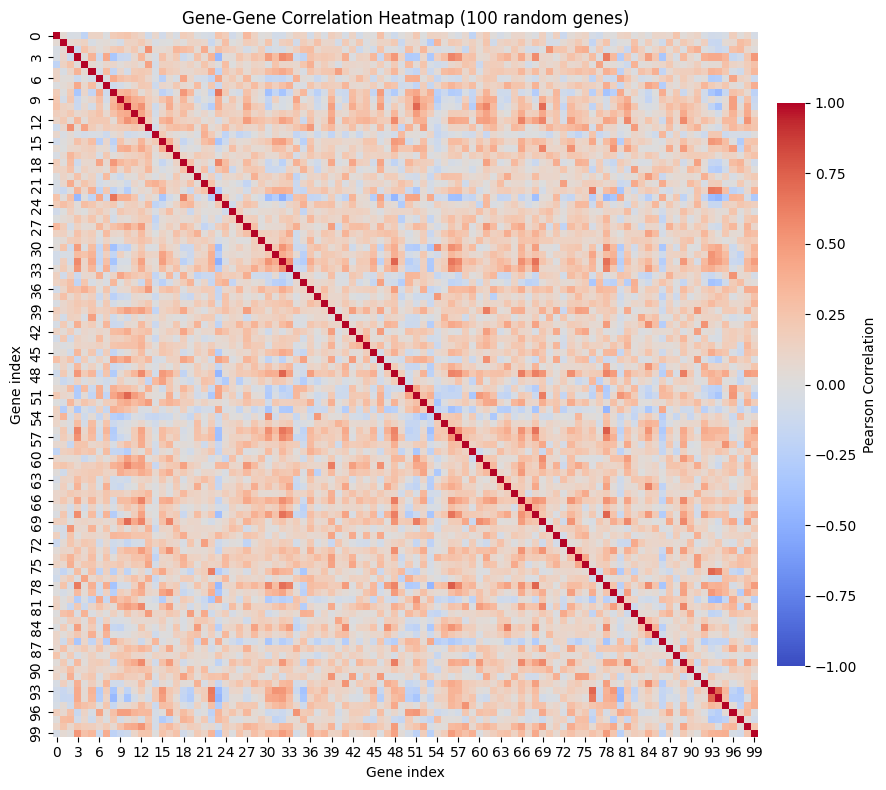

In [5]:
# Visualize correlation heatmap (sample of genes)
# Full matrix is too large (19k x 19k), so we sample a subset

import seaborn as sns

# Sample random genes for visualization
n_sample = 100
sample_idx = np.random.choice(num_genes, n_sample, replace=False)
pcc_sample = pcc_signed[sample_idx][:, sample_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(
    pcc_sample,
    cmap="coolwarm",        # clean diverging color map
    center=0,               # zero-centered for correlation
    vmin=-1, vmax=1,        # full PCC range
    square=True,
    linewidths=0.0,         # no gridlines
    cbar_kws={
        'label': 'Pearson Correlation',
        'shrink': 0.8,
        'pad': 0.02
    }
)
plt.title(f'Gene-Gene Correlation Heatmap ({n_sample} random genes)')
plt.xlabel('Gene index')
plt.ylabel('Gene index')
plt.tight_layout()
plt.show()

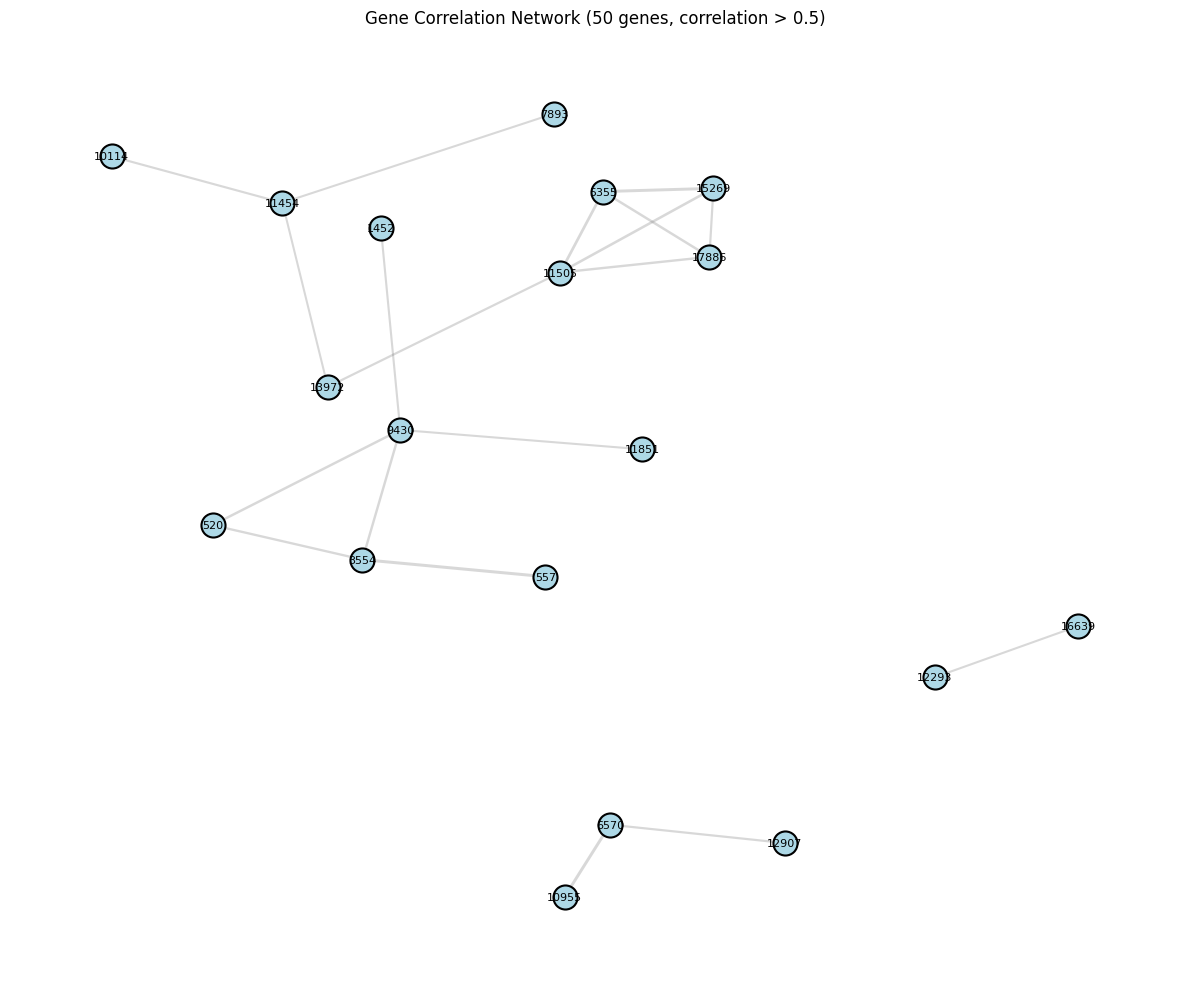

Subgraph: 19 nodes, 19 edges


In [6]:
# Alternative: Network graph visualization showing gene connections
# Visualize a small subgraph to see how genes connect via correlation edges

import networkx as nx

# Create a small subgraph (too many genes for readable visualization)
n_viz = 50
viz_genes = np.random.choice(num_genes, n_viz, replace=False)

# Build subgraph with edges where correlation > threshold
G = nx.Graph()
for i, gene_i in enumerate(viz_genes):
    for j, gene_j in enumerate(viz_genes):
        if i < j and pcc_cpu[gene_i, gene_j] > 0.5:  # Only strong correlations
            G.add_edge(gene_i, gene_j, weight=pcc_cpu[gene_i, gene_j])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Draw edges with thickness based on correlation strength
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], 
                        alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', 
                        edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f'Gene Correlation Network ({n_viz} genes, correlation > 0.5)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

In [7]:
# Filter weak edges: only keep correlations above threshold
# Reduces noise and keeps biologically meaningful relationships
threshold = 0.40
pcc_cpu[pcc_cpu < threshold] = 0.0

In [8]:
# Build KNN graph: keep top-K most correlated genes for each gene
# This creates the edge_index used by GCNConv in BulkFormer's GBFormer blocks

K = 20  # Each gene connects to 20 most similar genes

# Fast top-K selection using argpartition
topk_idx = np.argpartition(-pcc_cpu, K, axis=1)[:, :K]

# Create edge list: [source_nodes, target_nodes]
rows = np.repeat(np.arange(num_genes), K)  # Source genes
cols = topk_idx.reshape(-1)                 # Target genes (neighbors)

edge_index = torch.tensor([rows, cols], dtype=torch.long)
print(f"Graph edges: {edge_index.shape} ({num_genes * K} edges)")

Graph edges: torch.Size([2, 387140]) (387140 edges)


/tmp/ipykernel_18528/3984756597.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([rows, cols], dtype=torch.long)


In [9]:
# Preview: first 10 edges [source, target]
print("Edge index preview:")
print(edge_index[:, :10])

Edge index preview:
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  11,    1,    0,   12,   10,    5,    9, 7178,    8,    6]])


In [10]:
# Save graph for BulkFormer training
# - edge_index_top20.pt: used by GCNConv in model forward pass
# - adjacency_top20.npy: full correlation matrix (optional, for analysis)

import os
os.makedirs("./graph", exist_ok=True)

torch.save(edge_index, "./graph/edge_index_top20.pt")
np.save("./graph/adjacency_top20.npy", pcc_cpu)

print("✓ Saved to ./graph/")

✓ Saved to ./graph/


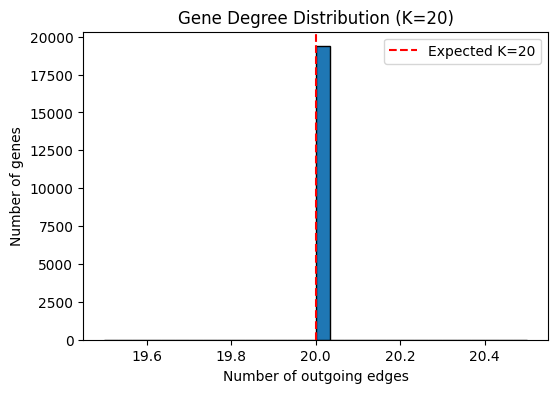

In [11]:
# Verify graph structure: degree distribution
# All genes should have degree ≈ K (each gene has K neighbors)

unique, counts = np.unique(rows, return_counts=True)

plt.figure(figsize=(6,4))
plt.hist(counts, bins=30, edgecolor='black')
plt.title(f"Gene Degree Distribution (K={K})")
plt.xlabel("Number of outgoing edges")
plt.ylabel("Number of genes")
plt.axvline(K, color='red', linestyle='--', label=f'Expected K={K}')
plt.legend()
plt.show()

In [ ]:
p